In [504]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



In [568]:
query = """select * from ballosodeuk.ynam.rfm_shopby_history_array_table,unnest(score_history) as s
where s.snapshot_dt = date("2025-01-02")"""

df = bq.query(query).to_dataframe()



c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [514]:
df.head()

,user_id,gender,age_group,join_group,platform,terms_agree_yn,first_order_dt,score_history,category_history,snapshot_dt,...,prev_trailing_term,term_diff,cycle_stddev,refund_rate,survival_prob,predicted_survival_time,total_accumulate_cash,total_accumulate_shoji,current_cash,current_shoji
0,9912e1a7-2d91-481a-a5a5-173cb000a62f,FEMALE,40,23-04,Android,true,2024-11-07,"[{'snapshot_dt': 2025-01-02, 'total_score': 2....","[{'snapshot_dt': 2025-01-02, 'ranking_1_1': '화...",2025-01-02,...,NaN,NaN,NaN,0.0,0.04,0.0,38206,27070,5038,13170
1,d22f188e-0234-41bf-afc9-17beb02bd74d,FEMALE,50,23-10,Android,true,2024-11-10,"[{'snapshot_dt': 2025-01-02, 'total_score': 6....","[{'snapshot_dt': 2025-01-02, 'ranking_1_1': '식...",2025-01-02,...,NaN,NaN,NaN,0.0,0.00,0.0,49855,5350,3963,217
2,393d5466-eeb7-4f37-b1f2-e9e3c340ba76,FEMALE,40,23-06,Android,false,2024-10-14,"[{'snapshot_dt': 2025-01-02, 'total_score': 3....","[{'snapshot_dt': 2025-01-02, 'ranking_1_1': '패...",2025-01-02,...,NaN,NaN,NaN,0.0,0.00,0.0,97389,33052,8620,15841
3,28fcba61-2a32-44ab-ac6e-5345823d8e31,None,None,23-10,iOS,true,2024-10-21,"[{'snapshot_dt': 2025-01-02, 'total_score': 4....","[{'snapshot_dt': 2025-01-02, 'ranking_1_1': '생...",2025-01-02,...,NaN,NaN,NaN,0.0,0.00,0.0,60087,49628,7,0
4,26ab5ab0-8c7a-4661-9fd1-1f9aa8d0eb98,FEMALE,50,23-08,Android,false,2024-10-10,"[{'snapshot_dt': 2025-01-02, 'total_score': 4....","[{'snapshot_dt': 2025-01-02, 'ranking_1_1': '식...",2025-01-02,...,NaN,NaN,NaN,0.0,0.00,0.0,143984,1011,2341,11


In [515]:
df[['user_id','cycle_length','r_score','f_score','m_score']].query("cycle_length=='장기' ")

,user_id,cycle_length,r_score,f_score,m_score
182,a71b7046-ad63-44aa-a153-2d1b842ed84e,장기,10,2,7
185,8bbd7754-905f-4109-92ed-d02cb814076e,장기,10,2,2
1136,ec2e5d89-d3a2-45f2-9ac0-8ad4b36abb00,장기,5,7,5
1370,1a27dc42-1746-4ebf-abc9-cc050afc7ecb,장기,10,6,4
1371,c8df200d-933a-438b-b33c-2775ff3002ce,장기,10,2,8
...,...,...,...,...,...
6970,1acb8f69-26e2-4a0c-95ea-0364cb0fe131,장기,10,6,9
6971,88978667-c277-4634-a647-d1de0bfb024a,장기,10,5,9
6972,1b932a8a-48ea-485c-aa96-1707aa23e4a0,장기,10,4,5
6977,3858ae72-f526-4384-ada1-2a83dc5ffd2a,장기,10,6,9


In [516]:
df.groupby('cycle_length').agg({
    'predicted_survival_time': 'mean',
    'r_score': 'mean',
    'f_score': 'mean',
    'm_score': 'mean'
})

,predicted_survival_time,r_score,f_score,m_score
cycle_length,,,,
단기,3.692201,6.320334,6.31337,8.291086
신규,3.178868,5.201509,1.0,4.675094
장기,46.425197,8.708661,4.15748,6.519685
중기,15.244275,6.824427,5.290076,7.759542
초단기,0.160279,5.897213,5.71777,8.34669


- 구매주기 가중치 (cycle_weight)
    - 구매주기가 길수록 가중치가 감소하도록 설계
    - 제곱근을 사용하여 극단적인 편향 완화
- 구매 품질 (monetary_quality)
    - 단순 구매금액이 아닌 구매건당 평균 금액 사용
    - 고객의 질적 가치 반영
- 구매빈도 보정 (frequency_factor)
    - 로그 스케일을 사용하여 구매빈도의 영향력 조정
    - 극단값의 영향 완화
- 생존기간 보정 (adj_survival_time)
    - 구매주기로 가중치를 부여한 생존기간 사용
    - 짧은 구매주기 고객의 과소평가 방지

- 짧은 구매주기 + 높은 구매빈도 고객의 가치를 적절히 반영
- 긴 구매주기 + 낮은 구매빈도 고객의 과대평가 방지
- 구매의 질적 측면까지 고려한 더 정확한 가치 평가 가능

### Init


Weight Optimization Results:
      Feature  Original     Optimized
0     Recency      0.30  2.425085e-01
1   Frequency      0.25  3.454213e-01
2    Monetary      0.25  1.490737e-01
3        Term      0.10  0.000000e+00
4   Term Diff      0.05  2.629965e-01
5  Volatility      0.05  2.386600e-17

Correlation with LTV:
Train - Original: 0.536, Optimized: 0.576
Test  - Original: 0.498, Optimized: 0.528


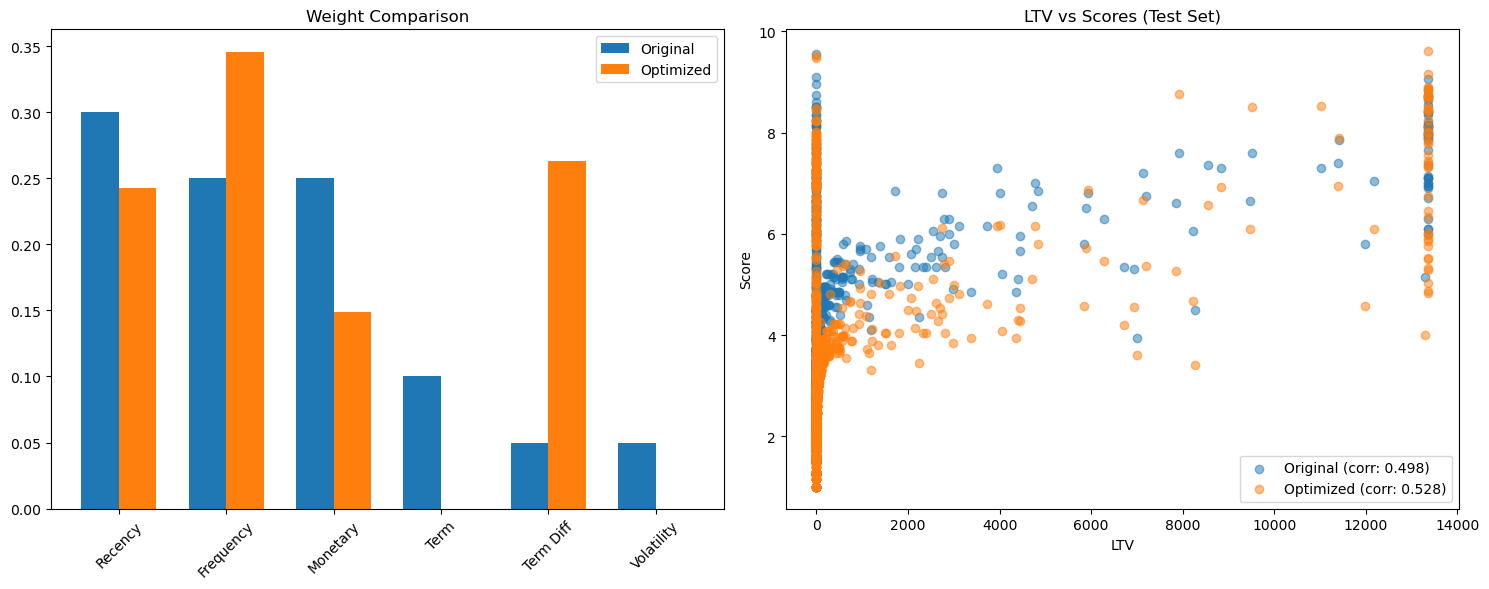

In [517]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(df):
    numeric_columns = [
        'current_trailing_term', 'm_data', 'predicted_survival_time',
        'r_score', 'f_score', 'm_score', 
        'term_score', 'term_diff_score', 'volatility_score'
    ]
    
    df_processed = df.copy()
    
    for col in numeric_columns:
        if col in df.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
            
            # 각 컬럼의 특성에 맞는 결측치 처리
            if col == 'current_trailing_term':
                # 재구매가 없는 경우, 전체 기간으로 대체
                median_term = df_processed[col].median()
                df_processed[col] = df_processed[col].fillna(median_term)
            elif col in ['m_data', 'predicted_survival_time']:
                # 금액이나 생존시간은 중앙값으로 대체
                df_processed[col] = df_processed[col].fillna(df_processed[col].median())
            else:
                # 스코어는 최소값으로 대체
                df_processed[col] = df_processed[col].fillna(df_processed[col].min())
    
    return df_processed

def calculate_adjusted_ltv(df):
    """
    LTV 계산 함수 - 재구매 없는 경우 강한 페널티, 재구매 빈도 가중치 강화
    """
    # 재구매 여부 확인
    has_repurchase = df['f_data'] > 1
    
    # 1. 구매 주기 가중치 계산 - 재구매 여부에 따라 차등
    cycle_weight = np.where(has_repurchase,
                          1 / np.sqrt(df['current_trailing_term'].replace(0, 0.1)),  # 재구매자
                          0.3 / np.sqrt(df['current_trailing_term'].replace(0, 0.1))) # 단일구매자 (70% 감소)
    
    # 2. 구매 빈도에 따른 가중치 강화
    frequency_factor = np.where(has_repurchase,
                              np.power(df['f_data'], 1.5),  # 재구매자 - 지수 증가
                              0.5)  # 단일구매자 - 50% 감소
    
    # 3. monetary_quality 계산 - 재구매 횟수 반영 강화
    monetary_quality = np.where(has_repurchase,
                              (df['m_data'] / df['f_data']) * np.log1p(df['f_data']),  # 재구매자
                              df['m_data'] * 0.7)  # 단일구매자 - 30% 감소
    
    # 4. monetary_quality 정규화 (이상치 처리)
    monetary_quality_norm = monetary_quality / np.percentile(monetary_quality, 50)
    monetary_quality_norm = np.clip(monetary_quality_norm, 0, 
                                  np.percentile(monetary_quality_norm, 95))
    
    # 5. 주기당 평균 구매액 계산 - 재구매 여부 반영
    avg_purchase_per_cycle = np.where(has_repurchase,
                                    (df['m_data'] / df['current_trailing_term'].replace(0, 1)) * 1.3,  # 재구매자 30% 증가
                                    (df['m_data'] / df['current_trailing_term'].replace(0, 1)) * 0.7)  # 단일구매자 30% 감소
    
    # 6. 생존 시간 조정 - 재구매 빈도 반영
    frequency_survival_bonus = np.where(has_repurchase,
                                      1 + np.log1p(df['f_data']) * 0.2,  # 구매 횟수에 따른 보너스
                                      1)
    adj_survival_time = df['predicted_survival_time'] * cycle_weight * frequency_survival_bonus
    
    # 7. 재구매 이력에 따른 최종 보정 계수
    repurchase_multiplier = np.where(has_repurchase,
                                   1 + np.log1p(df['f_data']) * 0.3,  # 재구매 횟수에 따른 추가 보너스
                                   0.6)  # 단일구매자 40% 감소
    
    # 8. 최종 LTV 계산
    adjusted_ltv = (avg_purchase_per_cycle * 
                   adj_survival_time * 
                   (1 + frequency_factor) * 
                   monetary_quality_norm *
                   repurchase_multiplier)  # 재구매 이력 보정 적용
    
    # 9. 극단값 처리 - 구매 횟수별 다른 기준 적용
    percentile_threshold = np.where(has_repurchase, 97, 95)  # 재구매자는 더 높은 상한선
    max_ltv = np.percentile(adjusted_ltv, percentile_threshold)
    adjusted_ltv = np.clip(adjusted_ltv, 0, max_ltv)
    
    return adjusted_ltv

def calculate_weighted_score(df, weights):
    """
    주어진 가중치로 total_score 계산
    """
    return (df['r_score'] * weights[0] + 
            df['f_score'] * weights[1] + 
            df['m_score'] * weights[2] + 
            df['term_score'] * weights[3] + 
            df['term_diff_score'] * weights[4] + 
            df['volatility_score'] * weights[5])

def objective_function(weights, df):
    """
    LTV와의 상관관계를 최대화하는 목적함수에 페널티 추가
    """
    total_score = calculate_weighted_score(df, weights)
    adjusted_ltv = calculate_adjusted_ltv(df)
    
    # 스코어와 LTV를 정규화
    total_score_norm = (total_score - total_score.mean()) / total_score.std()
    ltv_norm = (adjusted_ltv - adjusted_ltv.mean()) / adjusted_ltv.std()
    
    # 상관관계 계산
    correlation = np.corrcoef(total_score_norm, ltv_norm)[0,1]
    
    # 가중치 분산에 대한 페널티 (너무 극단적인 가중치 방지)
    weight_variance_penalty = np.var(weights) * 0.1
    
    return -(correlation - weight_variance_penalty)  # 최대화를 위해 음수 반환

# 데이터 전처리
df_processed = preprocess_data(df)

# Train/Test 분할
X_train, X_test = train_test_split(df_processed, test_size=0.2, random_state=42)

# 최적화 설정
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 가중치 합 = 1
bounds = [(0, 1) for _ in range(6)]  # 각 가중치는 0~1 사이
initial_weights = [0.3, 0.25, 0.25, 0.1, 0.05, 0.05]

# 최적화 실행
result = minimize(objective_function, 
                 initial_weights,
                 args=(X_train,),
                 constraints=constraints,
                 bounds=bounds,
                 method='SLSQP')

# 결과 분석 및 시각화
def analyze_results(original_weights, optimized_weights, train_data, test_data):
    results = {}
    
    # Train set 성능
    train_original_score = calculate_weighted_score(train_data, original_weights)
    train_optimized_score = calculate_weighted_score(train_data, optimized_weights)
    train_ltv = calculate_adjusted_ltv(train_data)
    
    # Test set 성능
    test_original_score = calculate_weighted_score(test_data, original_weights)
    test_optimized_score = calculate_weighted_score(test_data, optimized_weights)
    test_ltv = calculate_adjusted_ltv(test_data)
    
    results['train'] = {
        'original_correlation': np.corrcoef(train_original_score, train_ltv)[0,1],
        'optimized_correlation': np.corrcoef(train_optimized_score, train_ltv)[0,1]
    }
    
    results['test'] = {
        'original_correlation': np.corrcoef(test_original_score, test_ltv)[0,1],
        'optimized_correlation': np.corrcoef(test_optimized_score, test_ltv)[0,1]
    }
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 가중치 비교
    labels = ['Recency', 'Frequency', 'Monetary', 'Term', 'Term Diff', 'Volatility']
    x = np.arange(len(labels))
    width = 0.35
    
    ax1.bar(x - width/2, original_weights, width, label='Original')
    ax1.bar(x + width/2, optimized_weights, width, label='Optimized')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.legend()
    ax1.set_title('Weight Comparison')
    
    # LTV vs Score (Test set)
    ax2.scatter(test_ltv, test_original_score, alpha=0.5, 
               label=f"Original (corr: {results['test']['original_correlation']:.3f})")
    ax2.scatter(test_ltv, test_optimized_score, alpha=0.5, 
               label=f"Optimized (corr: {results['test']['optimized_correlation']:.3f})")
    ax2.set_xlabel('LTV')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.set_title('LTV vs Scores (Test Set)')
    
    plt.tight_layout()
    return results

# 결과 분석 실행
results = analyze_results(initial_weights, result.x, X_train, X_test)

# 최적화된 가중치 출력
weight_comparison = pd.DataFrame({
    'Feature': ['Recency', 'Frequency', 'Monetary', 'Term', 'Term Diff', 'Volatility'],
    'Original': initial_weights,
    'Optimized': result.x
})

print("\nWeight Optimization Results:")
print(weight_comparison)
print("\nCorrelation with LTV:")
print(f"Train - Original: {results['train']['original_correlation']:.3f}, Optimized: {results['train']['optimized_correlation']:.3f}")
print(f"Test  - Original: {results['test']['original_correlation']:.3f}, Optimized: {results['test']['optimized_correlation']:.3f}")


Weight Optimization Results:

Original weights: {'R': '0.200', 'F': '0.200', 'M': '0.200', 'Term': '0.200', 'Term_diff': '0.200', 'Vol': '0.200'}
Optimized weights: {'R': '0.243', 'F': '0.346', 'M': '0.149', 'Term': '0.000', 'Term_diff': '0.263', 'Vol': '0.000'}

Correlation with LTV:
Train - Original: 0.518, Optimized: 0.576
Test  - Original: 0.465, Optimized: 0.528

Validation Results:
Original correlation 95% CI: [0.434, 0.492]
Optimized correlation 95% CI: [0.495, 0.556]
Improvement: 0.063


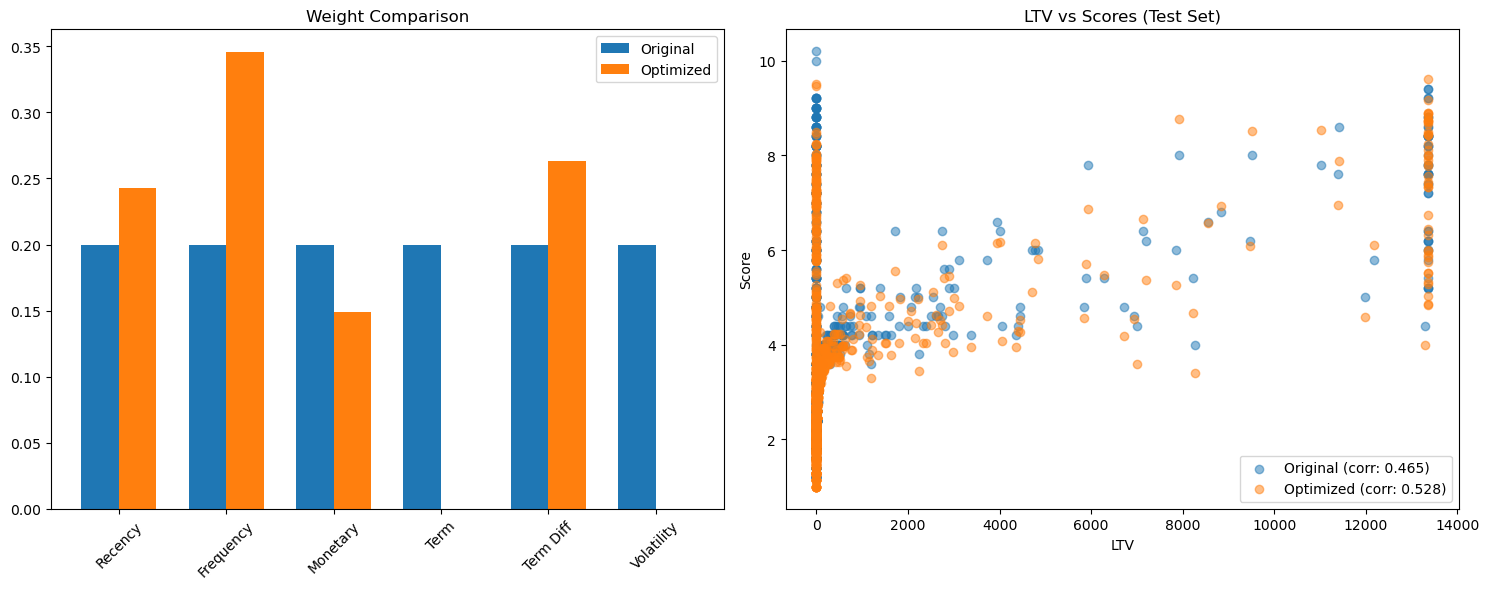

In [518]:
def validate_optimization(original_weights, optimized_weights, df):
    """
    최적화 결과의 통계적 유의성 검증 - 수정된 버전
    """
    original_score = calculate_weighted_score(df, original_weights)
    optimized_score = calculate_weighted_score(df, optimized_weights)
    ltv = calculate_adjusted_ltv(df)
    
    # 부트스트랩을 통한 상관계수의 신뢰구간 계산
    n_bootstrap = 1000
    original_corrs = []
    optimized_corrs = []
    n_samples = len(df)
    
    for _ in range(n_bootstrap):
        # 인덱스 대신 불리언 마스크 사용
        mask = np.random.choice([True, False], size=n_samples, p=[0.8, 0.2])
        
        # 마스크를 사용하여 데이터 샘플링
        boot_original = original_score[mask]
        boot_optimized = optimized_score[mask]
        boot_ltv = ltv[mask]
        
        # 상관계수 계산
        original_corrs.append(np.corrcoef(boot_original, boot_ltv)[0,1])
        optimized_corrs.append(np.corrcoef(boot_optimized, boot_ltv)[0,1])
    
    return {
        'original_ci': np.percentile(original_corrs, [2.5, 97.5]),
        'optimized_ci': np.percentile(optimized_corrs, [2.5, 97.5]),
        'improvement': np.mean(optimized_corrs) - np.mean(original_corrs)
    }

def analyze_results(original_weights, optimized_weights, train_data, test_data):
    """
    결과 분석 및 시각화 - 수정된 버전
    """
    results = {}
    
    # Train set 성능
    train_original_score = calculate_weighted_score(train_data, original_weights)
    train_optimized_score = calculate_weighted_score(train_data, optimized_weights)
    train_ltv = calculate_adjusted_ltv(train_data)
    
    # Test set 성능
    test_original_score = calculate_weighted_score(test_data, original_weights)
    test_optimized_score = calculate_weighted_score(test_data, optimized_weights)
    test_ltv = calculate_adjusted_ltv(test_data)
    
    results['train'] = {
        'original_correlation': np.corrcoef(train_original_score, train_ltv)[0,1],
        'optimized_correlation': np.corrcoef(train_optimized_score, train_ltv)[0,1]
    }
    
    results['test'] = {
        'original_correlation': np.corrcoef(test_original_score, test_ltv)[0,1],
        'optimized_correlation': np.corrcoef(test_optimized_score, test_ltv)[0,1]
    }
    
    # 시각화
    plt.figure(figsize=(15, 6))
    
    # 첫 번째 서브플롯: 가중치 비교
    plt.subplot(121)
    labels = ['Recency', 'Frequency', 'Monetary', 'Term', 'Term Diff', 'Volatility']
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, original_weights, width, label='Original')
    plt.bar(x + width/2, optimized_weights, width, label='Optimized')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.title('Weight Comparison')
    
    # 두 번째 서브플롯: LTV vs Score (Test set)
    plt.subplot(122)
    plt.scatter(test_ltv, test_original_score, alpha=0.5, 
               label=f"Original (corr: {results['test']['original_correlation']:.3f})")
    plt.scatter(test_ltv, test_optimized_score, alpha=0.5, 
               label=f"Optimized (corr: {results['test']['optimized_correlation']:.3f})")
    plt.xlabel('LTV')
    plt.ylabel('Score')
    plt.legend()
    plt.title('LTV vs Scores (Test Set)')
    
    plt.tight_layout()
    
    return results

# 최적화 과정
def optimize_multiple_starts(df, n_starts=10):
    """
    다양한 초기값으로 최적화 시도 - 수정된 버전
    """
    best_result = None
    best_score = float('-inf')
    
    for i in range(n_starts):
        # 랜덤 초기값 생성 (합이 1이 되도록)
        initial_weights = np.random.dirichlet(np.ones(6))
        
        result = minimize(objective_function, 
                        initial_weights,
                        args=(df,),
                        constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}),
                        bounds=[(0, 1) for _ in range(6)],
                        method='SLSQP',
                        options={'maxiter': 1000, 'ftol': 1e-8})
        
        if -result.fun > best_score:  # -result.fun because we minimized -correlation
            best_score = -result.fun
            best_result = result
    
    return best_result

# 결과 실행 및 출력
def run_optimization(df_processed):
    """
    전체 최적화 프로세스 실행
    """
    # Train/Test 분할
    X_train, X_test = train_test_split(df_processed, test_size=0.2, random_state=42)
    
    # 초기 가중치
    initial_weights = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
    
    # 최적화 실행
    best_result = optimize_multiple_starts(X_train)
    
    # 결과 분석
    results = analyze_results(initial_weights, best_result.x, X_train, X_test)
    validation_results = validate_optimization(initial_weights, best_result.x, X_test)
    
    # 결과 출력
    print("\nWeight Optimization Results:")
    print("\nOriginal weights:", dict(zip(['R', 'F', 'M', 'Term', 'Term_diff', 'Vol'], 
                                        [f"{w:.3f}" for w in initial_weights])))
    print("Optimized weights:", dict(zip(['R', 'F', 'M', 'Term', 'Term_diff', 'Vol'], 
                                       [f"{w:.3f}" for w in best_result.x])))
    
    print("\nCorrelation with LTV:")
    print(f"Train - Original: {results['train']['original_correlation']:.3f}, "
          f"Optimized: {results['train']['optimized_correlation']:.3f}")
    print(f"Test  - Original: {results['test']['original_correlation']:.3f}, "
          f"Optimized: {results['test']['optimized_correlation']:.3f}")
    
    print("\nValidation Results:")
    print(f"Original correlation 95% CI: "
          f"[{validation_results['original_ci'][0]:.3f}, {validation_results['original_ci'][1]:.3f}]")
    print(f"Optimized correlation 95% CI: "
          f"[{validation_results['optimized_ci'][0]:.3f}, {validation_results['optimized_ci'][1]:.3f}]")
    print(f"Improvement: {validation_results['improvement']:.3f}")
    
    return best_result, results, validation_results

# Preprocess your data
df_processed = preprocess_data(df)

# Run the optimization
best_result, results, validation_results = run_optimization(df_processed)


=== 가중치 최적화 결과 ===

초기 가중치:
R: 0.100
F: 0.350
M: 0.350
Term: 0.010
Term_diff: 0.050
Vol: 0.050

최적화된 가중치:
R: 0.206
F: 0.444
M: 0.350
Term: 0.000
Term_diff: 0.000
Vol: 0.000

LTV와의 상관관계:
학습 데이터 - 초기: 0.520, 최적화: 0.546
테스트 데이터 - 초기: 0.471, 최적화: 0.503


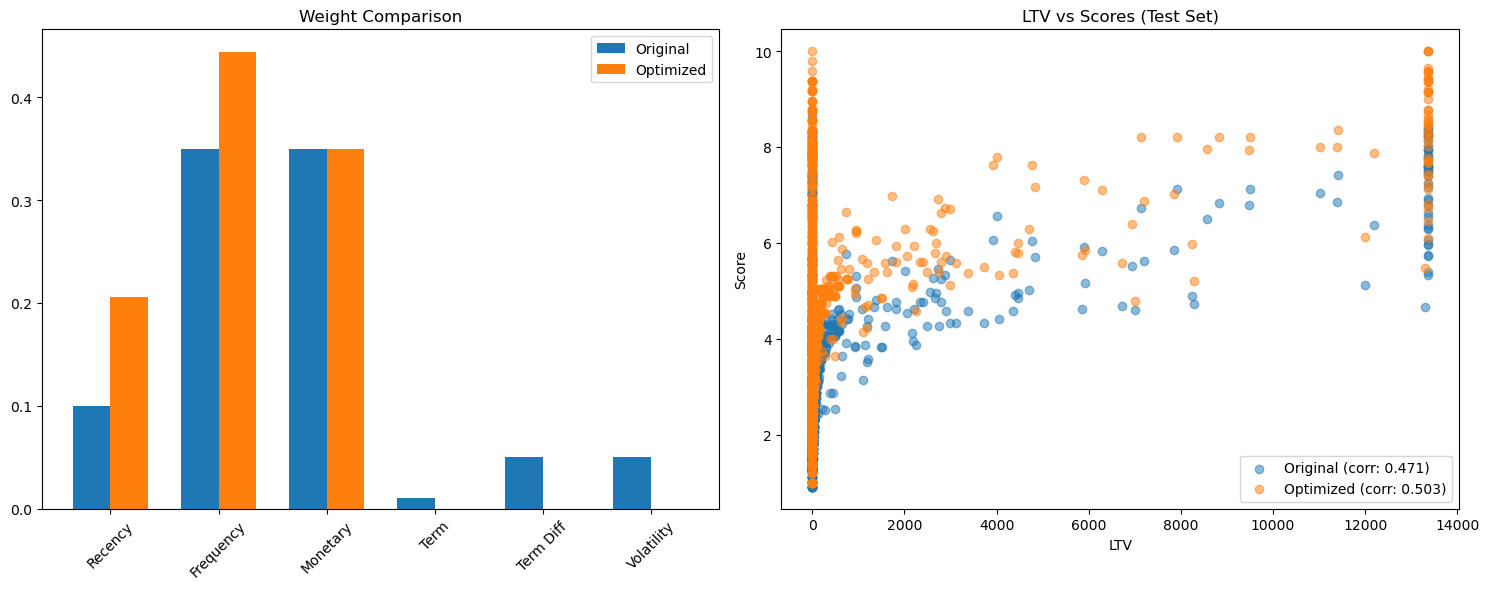

In [519]:
def objective_function(weights, df):
    """
    각 지표별 상대적 중요도를 고려하는 목적함수
    """
    total_score = calculate_weighted_score(df, weights)
    adjusted_ltv = calculate_adjusted_ltv(df)
    
    # 스코어와 LTV를 정규화
    total_score_norm = (total_score - total_score.mean()) / total_score.std()
    ltv_norm = (adjusted_ltv - adjusted_ltv.mean()) / adjusted_ltv.std()
    
    # 상관관계 계산
    correlation = np.corrcoef(total_score_norm, ltv_norm)[0,1]
    
    # 각 가중치별 중요도 보너스
    importance_factors = [0.2, 0.3, 0.2, 0.15, 0.1, 0.05]  # R, F, M, Term, Term_diff, Vol
    weight_bonus = sum(w * f for w, f in zip(weights, importance_factors))
    
    # 가중치 분산에 대한 페널티 (너무 극단적인 가중치 방지)
    weight_variance_penalty = np.var(weights) * 0.1
    
    return -(correlation + weight_bonus - weight_variance_penalty)

def optimize_multiple_starts(df, n_starts=10):
    """
    각 지표별 최소 가중치를 보장하는 최적화
    """
    best_result = None
    best_score = float('-inf')
    
    # 각 지표별 최소 가중치 설정
    min_weights = {
        'R': 0.0,      # Recency
        'F': 0.20,      # Frequency
        'M': 0.35,      # Monetary
        'Term': 0.00,   # 거래기간
        'Term_diff': 0.00,  # 거래간격
        'Vol': 0.00     # 변동성
    }
    
    for i in range(n_starts):
        # 초기 가중치 설정
        initial_weights = np.random.dirichlet(np.array([0.1, 0.35, 0.35, 0.1, 0.05, 0.05]))
        
        # 각 가중치별 최소값 제약조건 생성
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # 합이 1
        for idx, min_weight in enumerate(min_weights.values()):
            constraints.append({
                'type': 'ineq',
                'fun': lambda x, i=idx, min_w=min_weight: x[i] - min_w
            })
        
        result = minimize(objective_function, 
                        initial_weights,
                        args=(df,),
                        constraints=constraints,
                        bounds=[(0, 1) for _ in range(6)],
                        method='SLSQP',
                        options={'maxiter': 1000, 'ftol': 1e-8})
        
        if -result.fun > best_score:
            best_score = -result.fun
            best_result = result
    
    return best_result

# 결과 분석 및 시각화
def analyze_results(original_weights, optimized_weights, train_data, test_data):
    results = {}
    
    # Train set 성능
    train_original_score = calculate_weighted_score(train_data, original_weights)
    train_optimized_score = calculate_weighted_score(train_data, optimized_weights)
    train_ltv = calculate_adjusted_ltv(train_data)
    
    # Test set 성능
    test_original_score = calculate_weighted_score(test_data, original_weights)
    test_optimized_score = calculate_weighted_score(test_data, optimized_weights)
    test_ltv = calculate_adjusted_ltv(test_data)
    
    results['train'] = {
        'original_correlation': np.corrcoef(train_original_score, train_ltv)[0,1],
        'optimized_correlation': np.corrcoef(train_optimized_score, train_ltv)[0,1]
    }
    
    results['test'] = {
        'original_correlation': np.corrcoef(test_original_score, test_ltv)[0,1],
        'optimized_correlation': np.corrcoef(test_optimized_score, test_ltv)[0,1]
    }
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 가중치 비교
    labels = ['Recency', 'Frequency', 'Monetary', 'Term', 'Term Diff', 'Volatility']
    x = np.arange(len(labels))
    width = 0.35
    
    ax1.bar(x - width/2, original_weights, width, label='Original')
    ax1.bar(x + width/2, optimized_weights, width, label='Optimized')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.legend()
    ax1.set_title('Weight Comparison')
    
    # LTV vs Score (Test set)
    ax2.scatter(test_ltv, test_original_score, alpha=0.5, 
               label=f"Original (corr: {results['test']['original_correlation']:.3f})")
    ax2.scatter(test_ltv, test_optimized_score, alpha=0.5, 
               label=f"Optimized (corr: {results['test']['optimized_correlation']:.3f})")
    ax2.set_xlabel('LTV')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.set_title('LTV vs Scores (Test Set)')
    
    plt.tight_layout()
    return results

def validate_optimization(original_weights, optimized_weights, df):
    """
    최적화 결과의 통계적 유의성 검증 - 수정된 버전
    """
    original_score = calculate_weighted_score(df, original_weights)
    optimized_score = calculate_weighted_score(df, optimized_weights)
    ltv = calculate_adjusted_ltv(df)
    
    # 부트스트랩을 통한 상관계수의 신뢰구간 계산
    n_bootstrap = 1000
    original_corrs = []
    optimized_corrs = []
    n_samples = len(df)
    
    for _ in range(n_bootstrap):
        # 인덱스 대신 불리언 마스크 사용
        mask = np.random.choice([True, False], size=n_samples, p=[0.8, 0.2])
        
        # 마스크를 사용하여 데이터 샘플링
        boot_original = original_score[mask]
        boot_optimized = optimized_score[mask]
        boot_ltv = ltv[mask]
        
        # 상관계수 계산
        original_corrs.append(np.corrcoef(boot_original, boot_ltv)[0,1])
        optimized_corrs.append(np.corrcoef(boot_optimized, boot_ltv)[0,1])
    
    return {
        'original_ci': np.percentile(original_corrs, [2.5, 97.5]),
        'optimized_ci': np.percentile(optimized_corrs, [2.5, 97.5]),
        'improvement': np.mean(optimized_corrs) - np.mean(original_corrs)
    }

def run_optimization(df_processed):
    """
    전체 최적화 프로세스 실행
    """
    # Train/Test 분할
    X_train, X_test = train_test_split(df_processed, test_size=0.2, random_state=42)
    
    # 초기 가중치 설정
    initial_weights = {
        'R': 0.1,      # Recency
        'F': 0.35,      # Frequency
        'M': 0.35,      # Monetary
        'Term': 0.01,   # 거래기간
        'Term_diff': 0.05,  # 거래간격
        'Vol': 0.05     # 변동성
    }
    
    # 최적화 실행
    best_result = optimize_multiple_starts(X_train)
    

    
    # 결과 분석
    results = analyze_results(list(initial_weights.values()), best_result.x, X_train, X_test)
    validation_results = validate_optimization(list(initial_weights.values()), best_result.x, X_test)
    
    # 결과 출력
    print("\n=== 가중치 최적화 결과 ===")
    print("\n초기 가중치:")
    for k, v in initial_weights.items():
        print(f"{k}: {v:.3f}")
    
    print("\n최적화된 가중치:")
    optimized_weights = dict(zip(initial_weights.keys(), best_result.x))
    for k, v in optimized_weights.items():
        print(f"{k}: {v:.3f}")
    
    print("\nLTV와의 상관관계:")
    print(f"학습 데이터 - 초기: {results['train']['original_correlation']:.3f}, "
          f"최적화: {results['train']['optimized_correlation']:.3f}")
    print(f"테스트 데이터 - 초기: {results['test']['original_correlation']:.3f}, "
          f"최적화: {results['test']['optimized_correlation']:.3f}")
    
    return best_result, results, validation_results

# Preprocess your data
df_processed = preprocess_data(df)

# Run the optimization
best_result, results, validation_results = run_optimization(df_processed)

### RFM 등급 증분 테스트

In [571]:
prev_ = prev[['grade','total_score','cut1','cut2','cut3']]

cur_ = cur[['grade','total_score','cut1','cut2','cut3']]

In [575]:
def assign_grade(score):
    if score > 7.15:
        return 'VIP'
    elif score > 4.504:
        return 'GOLD'
    elif score > 3.15:
        return 'SILVER'
    # elif score > q[0.1]:
    #     return 'BRONZE'
    else:
        return 'IRON'

cur_copy = cur_.copy()
cur_copy['grade'] = cur_copy['total_score'].apply(lambda x: assign_grade(x))

In [572]:
prev_.groupby('grade').agg({
    'cut1':'mean',
    'cut2':'mean',
    'cut3':['mean','count'],
    })

cut1   cut2  cut3      
        mean   mean  mean count
grade                          
GOLD    3.15  4.504  7.15  1398
IRON    3.15  4.504  7.15  2798
SILVER  3.15  4.504  7.15  2089
VIP     3.15  4.504  7.15   696

In [574]:
cur_.groupby('grade').agg({
    'cut1':'mean',
    'cut2':'mean',
    'cut3':['mean','count'],
    })

cut1  cut2  cut3      
        mean  mean  mean count
grade                         
GOLD    3.15  4.55  7.24  1696
IRON    3.15  4.55  7.24  3387
SILVER  3.15  4.55  7.24  2537
VIP     3.15  4.55  7.24   841

In [576]:
cur__ = cur_copy[['grade','total_score','cut1','cut2','cut3']]
cur__.groupby('grade').agg({
    'cut1':'mean',
    'cut2':'mean',
    'cut3':['mean','count'],
    })

cut1  cut2  cut3      
        mean  mean  mean count
grade                         
GOLD    3.15  4.55  7.24  1769
IRON    3.15  4.55  7.24  3387
SILVER  3.15  4.55  7.24  2422
VIP     3.15  4.55  7.24   883

In [591]:
prev.groupby('grade').agg({
    'total_score': 'mean',
    'cut1': 'mean',
    'cut2': 'mean', 
    'cut3': 'mean',
    'r_data': 'mean',
    'f_data': 'mean',
    'm_data': 'median',
    'ar_data' : 'median',
    'term_score': 'mean',
    'term_diff_score': 'mean',
    'volatility_score': 'mean',
    'refund_rate': 'mean',
    'survival_prob': 'mean',
    'predicted_survival_time': 'mean',
    'total_accumulate_cash': 'mean',
    'total_accumulate_shoji': 'mean',
    'current_cash': 'mean',
    'current_shoji': 'mean'
})


,total_score,cut1,cut2,cut3,r_data,f_data,m_data,ar_data,term_score,term_diff_score,volatility_score,refund_rate,survival_prob,predicted_survival_time,total_accumulate_cash,total_accumulate_shoji,current_cash,current_shoji
grade,,,,,,,,,,,,,,,,,,
GOLD,5.523705,3.15,4.504,7.15,16.099428,1.610157,5144.5,3598.0,3.875536,1.221745,1.111588,0.0,0.546917,7.833333,65835.298999,15965.58226,12695.896996,5443.016452
IRON,2.442237,3.15,4.504,7.15,36.316297,1.000357,1411.0,1411.0,1.066833,1.013939,1.002502,0.0,0.306419,2.114010,57968.107934,11994.967834,10889.732309,4621.055039
SILVER,3.781738,3.15,4.504,7.15,25.270943,1.046912,2836.0,2822.0,1.306367,1.004787,1.002872,0.0,0.438712,3.967449,58810.660603,11126.945428,12704.009095,4839.4854
VIP,8.413448,3.15,4.504,7.15,13.466954,4.110632,12747.0,3344.0,6.102011,5.255747,2.966954,0.0,0.512385,6.216954,80849.137931,28465.234195,12531.820402,6346.311782


In [592]:
cur.groupby('grade').agg({
    'total_score': 'mean',
    'cut1': 'mean',
    'cut2': 'mean', 
    'cut3': 'mean',
    'r_data': 'mean',
    'f_data': 'mean',
    'm_data': 'median',
    'ar_data' : 'median',
    'term_score': 'mean',
    'term_diff_score': 'mean',
    'volatility_score': 'mean',
    'refund_rate': 'mean',
    'survival_prob': 'mean',
    'predicted_survival_time': 'mean',
    'total_accumulate_cash': 'mean',
    'total_accumulate_shoji': 'mean',
    'current_cash': 'mean',
    'current_shoji': 'mean'
})


,total_score,cut1,cut2,cut3,r_data,f_data,m_data,ar_data,term_score,term_diff_score,volatility_score,refund_rate,survival_prob,predicted_survival_time,total_accumulate_cash,total_accumulate_shoji,current_cash,current_shoji
grade,,,,,,,,,,,,,,,,,,
GOLD,5.623325,3.15,4.55,7.24,15.538915,1.693986,4668.0,3046.75,4.168632,1.274764,1.129127,0.0,0.538485,8.392099,66409.954599,15735.415094,14423.252948,3369.214033
IRON,2.468264,3.15,4.55,7.24,34.762622,1.001181,1340.0,1340.00,1.079126,1.014762,1.003838,0.0,0.335805,2.131975,58126.72424,11234.319457,10970.751402,3533.630351
SILVER,3.823122,3.15,4.55,7.24,25.478124,1.069373,2822.0,2802.00,1.415845,1.005912,1.003547,0.0,0.435755,3.759559,58160.233346,9598.727237,13949.600709,3277.129681
VIP,8.429429,3.15,4.55,7.24,14.313912,4.057075,10971.0,3099.50,6.189061,5.30321,2.915577,0.0,0.490499,5.624257,76906.49346,27594.545779,12767.269917,4343.395957


In [496]:
q = df.total_score.quantile([0.4,0.7,0.9])
def assign_grade(score, q):
    if score > q[0.9]:
        return 'VIP'
    elif score > q[0.7]:
        return 'GOLD'
    elif score > q[0.4]:
        return 'SILVER'
    # elif score > q[0.1]:
    #     return 'BRONZE'
    else:
        return 'IRON'

df['q'] = df['total_score'].apply(lambda x: assign_grade(x, q))

In [447]:
df.groupby('q').agg({'user_id':'count'})

,user_id
q,
GOLD,1713
IRON,3456
SILVER,2614
VIP,851


In [464]:
df.groupby('q').agg({
    'predicted_survival_time': 'mean',
    'r_data': 'mean',
    'f_data': 'mean',
    'm_data': 'mean'
})

,predicted_survival_time,r_data,f_data,m_data
q,,,,
GOLD,7.253940,19.383538,1.669586,6864.118506
IRON,2.839410,27.7364,1.008391,1222.313079
SILVER,3.404361,32.057383,1.082632,3124.398623
VIP,4.809636,16.974148,4.077556,16087.237368


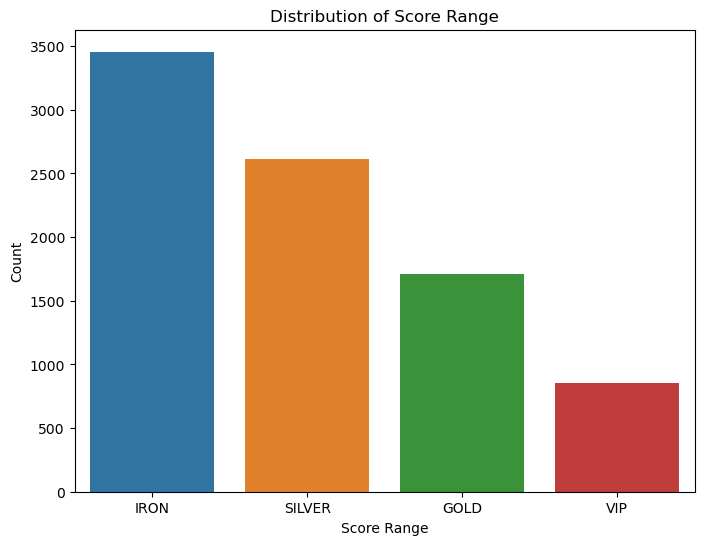

In [448]:
import seaborn as sns
import matplotlib_inline
import matplotlib.pyplot as plt




plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='q')
plt.title('Distribution of Score Range')
plt.xlabel('Score Range')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='f_data', ylabel='m_data'>

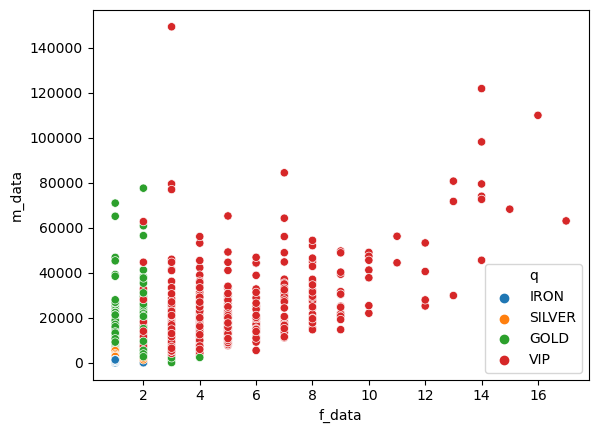

In [449]:
sns.scatterplot(data=df,x='f_data',y='m_data',hue='q')

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1

<Axes: xlabel='f_data', ylabel='Count'>

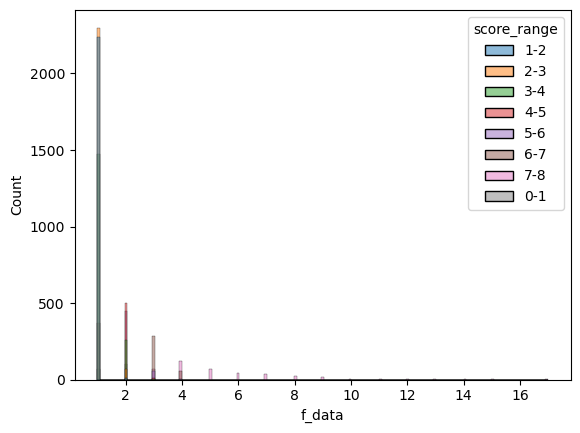

In [450]:
sns.histplot(data=df[df['m_data']<100000],x='f_data',hue='score_range')

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1

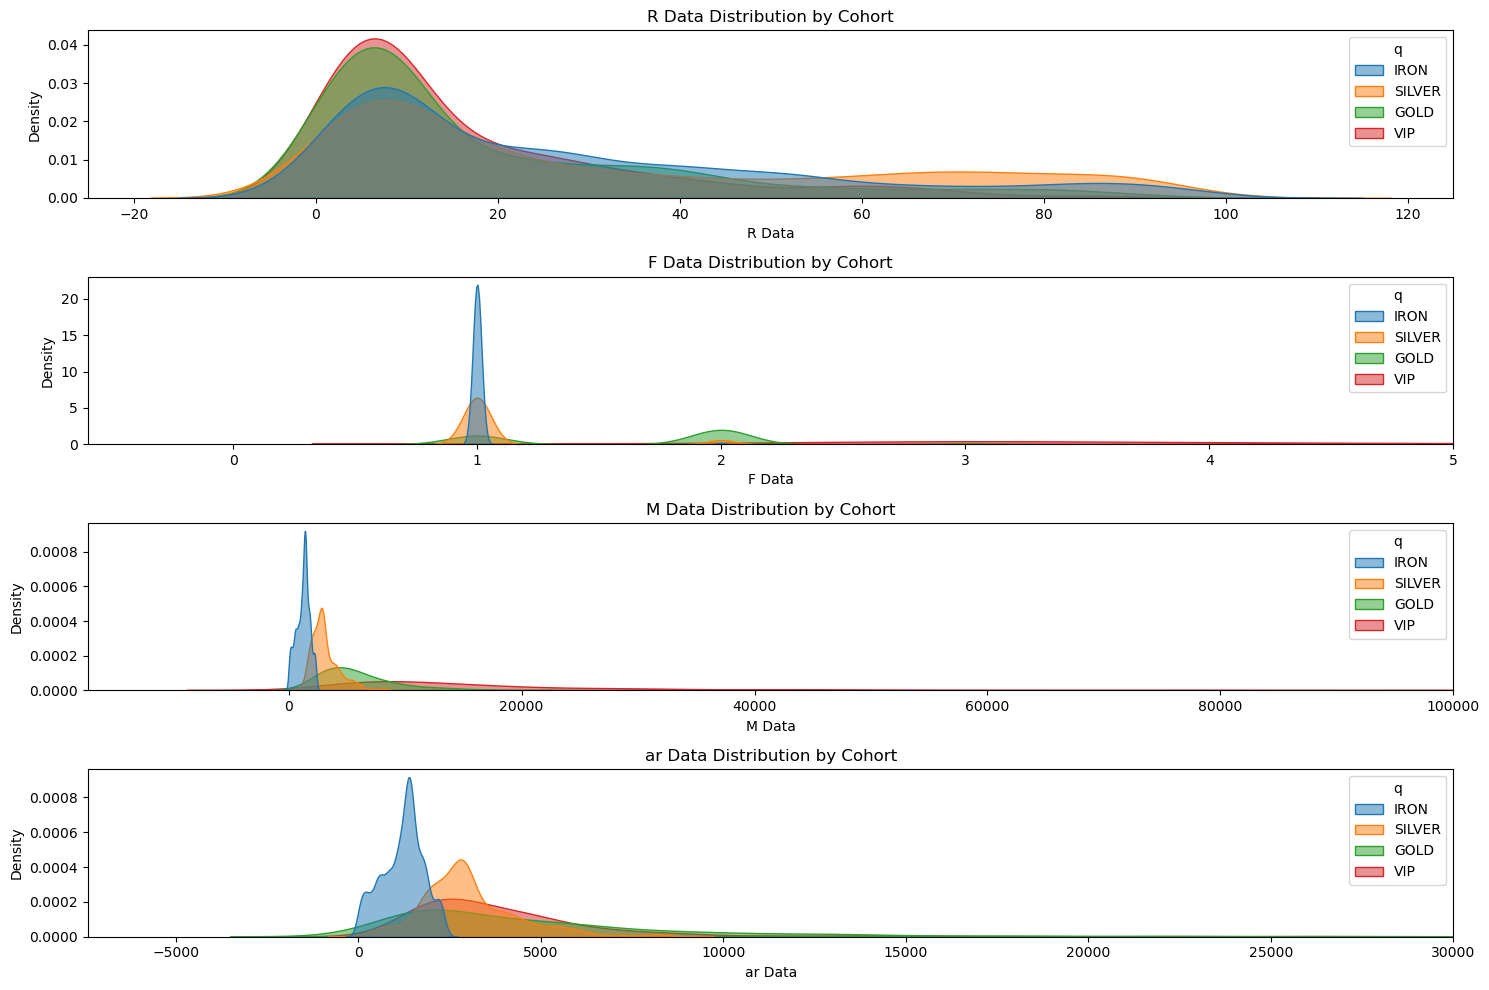

In [461]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(15, 10))

# R 데이터 분포
plt.subplot(4, 1, 1)
sns.kdeplot(data=df, x='r_data', hue='q', fill=True, common_norm=False, alpha=0.5)
plt.title('R Data Distribution by Cohort')
plt.xlabel('R Data')
plt.ylabel('Density')

# F 데이터 분포
plt.subplot(4, 1, 2)
sns.kdeplot(data=df, x='f_data', hue='q', fill=True, common_norm=False, alpha=0.5)
plt.title('F Data Distribution by Cohort')
plt.xlabel('F Data')
plt.ylabel('Density')
plt.xlim(right=5)

# M 데이터 분포
plt.subplot(4, 1, 3)
sns.kdeplot(data=df, x='m_data', hue='q', fill=True, common_norm=False, alpha=0.5)
plt.title('M Data Distribution by Cohort')
plt.xlabel('M Data')
plt.ylabel('Density')
plt.xlim(right=100000)

# ar 데이터 분포
plt.subplot(4, 1, 4)
sns.kdeplot(data=df, x='ar_data', hue='q', fill=True, common_norm=False, alpha=0.5)
plt.title('ar Data Distribution by Cohort')
plt.xlabel('ar Data')
plt.ylabel('Density')
plt.xlim(right=30000)

plt.tight_layout()
plt.show()


In [404]:

df.columns

Index(['user_id', 'gender', 'age_group', 'join_group', 'platform',
       'terms_agree_yn', 'first_order_dt', 'score_history', 'category_history',
       'snapshot_dt', 'total_score', 'risk_level', 'cycle_length', 'r_score',
       'f_score', 'm_score', 'term_score', 'term_diff_score',
       'volatility_score', 'r_data', 'f_data', 'm_data', 'ar_data',
       'current_trailing_term', 'prev_trailing_term', 'term_diff',
       'cycle_stddev', 'refund_rate', 'survival_prob',
       'predicted_survival_time', 'total_accumulate_cash',
       'total_accumulate_shoji', 'current_cash', 'current_shoji', 'ntile',
       'score_range'],
      dtype='object')

In [405]:
print(df['score_range'].head())  # 데이터 확인
print(df['score_range'].isnull().sum())  # Null 값 확인


0    1-2
1    1-2
2    1-2
3    1-2
4    2-3
Name: score_range, dtype: category
Categories (10, object): ['0-1' < '1-2' < '2-3' < '3-4' ... '6-7' < '7-8' < '8-9' < '9-10']
0


In [411]:
df[['r_score']]

,r_score
0,6
1,6
2,6
3,6
4,5
...,...
8629,4
8630,4
8631,4
8632,4


---

In [375]:
eval

,score_range,mean_score,min_score,max_score,users,r_min,r_max,f_min,f_max,m_min,m_max,t_min,t_max,d_min,d_max,v_min,v_max,ar_min,ar_max
0,0-1,1.000000,1.00,1.0,24,71,99,1,1,556,827,NaN,NaN,NaN,NaN,NaN,NaN,556.00,827.00
1,1-2,1.699577,1.10,2.0,1772,0,99,1,1,3,1496,5.0,79.0,-5.2,10.3,11.0,19.0,3.00,1496.00
2,2-3,2.507498,2.05,3.0,2314,0,100,1,2,17,2964,1.0,93.0,-5.7,0.0,10.0,18.0,17.00,2964.00
3,3-4,3.494516,3.05,4.0,1933,0,99,1,2,15,8990,1.0,91.0,-42.0,-1.0,1.0,59.0,7.50,8990.00
4,4-5,4.462856,4.05,5.0,879,0,93,1,3,37,70965,1.0,92.0,-29.5,28.5,1.0,42.0,18.50,70965.00
5,5-6,5.515495,5.05,6.0,555,0,92,1,3,94,62743,1.0,99.0,-43.0,36.0,0.0,61.0,31.33,31371.50
6,6-7,6.471603,6.05,7.0,368,0,98,2,4,1967,77606,1.0,93.0,-42.0,42.5,1.0,60.0,594.25,38803.00
7,7-8,7.549025,7.05,8.0,359,0,92,2,5,2216,79501,1.0,70.0,-40.5,38.5,0.0,57.0,733.25,26500.33
8,8-9,8.512259,8.05,9.0,363,0,84,2,17,4204,149331,1.0,46.5,-45.5,27.5,0.0,64.0,914.33,49777.00
9,9-10,9.200746,9.05,9.6,67,0,21,3,15,8822,80726,1.0,16.7,-23.0,3.7,0.0,33.0,1649.29,7500.00


In [313]:
q = """
  with enter_cashshop as
    (
    SELECT 
      distinct user_id
    FROM `ballosodeuk.dw.fact_airbridge_event`
    , UNNEST(event_detail) ed
    WHERE 1=1
    AND event_dt >= '2024-12-30'
    AND event_category = 'c__shopping_home__quick__btn (App)'
    AND event_action LIKE '/v2/prv/shopping/coupon%'

    )


  ,enter_cashshop2 as 
    (
      select distinct user_id
      FROM `ballosodeuk.dw.fact_airbridge_event`
      , UNNEST(event_detail) ed
      WHERE 1=1
      AND event_dt >= '2024-12-30'
      AND event_category = 'c__all_income_s_money__to_exchange__btn (App)'
      -- AND event_action LIKE '/v2/prv/shopping/coupon%'

    )

  ,click_coupon as (
    -- 금액권 클릭
    -- 'tap_go__cp_detail (App)' / '구매_인기쿠폰' / '쇼핑지원금 100원권'
    SELECT 
      distinct user_id
    FROM `ballosodeuk.dw.fact_airbridge_event`
    , UNNEST(event_detail) ed
    WHERE 1=1
    AND event_dt >= '2024-12-30'
    AND event_category = 'tap_go__cp_detail (App)'
    AND event_label = '구매_인기쿠폰'
    AND event_action LIKE '쇼핑지원금%'

      -- , event_action
  ),

  view_cash_page as 
    (-- 금액권 페이지 조회
    -- 'view_get__page (App)' / '상품_상세' / 

    -- 쇼핑지원금 교환하기 클릭
    -- 'tap_go__cp_detail_buy (App)' / '쇼핑지원금 교환하기' / 

    -- 쇼핑지원금 교환하기 팝업
    -- 'view_get__pop (App)' / '상품_구매불가' OR '상품_구매가능' / '쇼핑지원금 100원권'
    SELECT 
      distinct user_id
    FROM `ballosodeuk.dw.fact_airbridge_event`
    , UNNEST(event_detail) ed
    WHERE 1=1
    AND event_dt >= '2024-12-30'
    AND event_category = 'view_get__pop (App)'
    AND event_label IN ('상품_구매불가', '상품_구매가능')
    AND event_action LIKE '쇼핑지원금%'
    ),

  transfer as (
    -- 쇼핑지원금 교환권 전환 건수 - 샵바이
    select b.wk_id as user_id
    from
      (SELECT 
        member_no
      FROM `ballosodeuk.dw.fact_shopby_reward` 
      WHERE 1=1
      AND register_dt >= '2024-12-30'
      AND reason_detail IN ('쇼핑지원금 교환권 적립', '쇼핑지원금 상품권 적립')) a

    left join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    )

  select user_id, current_cash
  from ballosodeuk.dw.dim_airbridge_member 
  where user_id in (
    select distinct user_id
    from
      (
      -- SELECT user_id 
      -- FROM transfer
      -- UNION ALL
      -- SELECT user_id 
      -- FROM view_cash_page
      -- UNION ALL
      -- SELECT user_id 
      -- FROM click_coupon
      -- UNION ALL
      SELECT user_id 
      FROM enter_cashshop
      UNION ALL
      SELECT user_id 
      FROM enter_cashshop2
      )
  )

"""

In [314]:
ff = bq.query(q).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [315]:
ff['current_cash'] = ff['current_cash'].apply(pd.to_numeric, errors='coerce')
ff.max()

user_id         fffff0da-172e-421f-87be-12324d714cbd
current_cash                                350335.0
dtype: object

In [316]:
ff

,user_id,current_cash
0,03c76efe-aaa4-44e2-bf21-c6d5fcf87d57,2457.0
1,5a1fe291-b2eb-41ce-a3e4-03f5886a191d,29239.0
2,09e96902-4428-408f-8076-9d1ac63398c7,6418.0
3,d9d8b930-fa94-48de-9ff0-284a068381bb,4067.0
4,a8a4a1ae-20a1-4e96-bd0e-6440beee5b0b,6573.0
...,...,...
109466,13b22087-3c7e-4639-803e-65b98b5cb5f0,0.0
109467,c943d280-5a98-45c6-9aaa-134e50b4300d,0.0
109468,79436588-6302-473d-9624-c40f1f78929a,0.0
109469,911b567b-0d70-46b6-8836-ff8f7de39815,0.0


In [317]:
import pandas as pd

bins = [
    0,          # 시작값
    1000,       # 1천
    1500,       # 1천5백
    2000,       # 2천
    5000,       # 5천
    10000,      # 1만
    15000,      # 1만5천
    20000,      # 2만
    30000,      # 3만
    50000,      # 5만
    100000,     # 10만
    float('inf')  # 무한대 (10만 이상)
]

labels = [
    '1 ~  1,000',
    '1,000 ~ 1,500',
    '1,500 ~ 2,000',
    '2,000 ~ 5,000',
    '5,000 ~  10,000',
    '10,000 ~ 15,000',
    '15,000 ~ 20,000',
    '20,000 ~ 30,000',
    '30,000 ~ 50,000',
    '50,000 ~ 100,000',
    '100,000 ~'
]

ff['range'] = pd.cut(ff['current_cash'], bins=bins, labels=labels)

In [318]:
ff.groupby('range').agg({'user_id':'count'})

print(ff['current_cash'].sum())
print(ff['current_cash'].sum() /len(ff.query("current_cash > 0")))



2037078680.0
18742.098445119147


C:\Users\Owner\AppData\Local\Temp\ipykernel_29428\3226170181.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ff.groupby('range').agg({'user_id':'count'})


In [319]:
len(ff.query("current_cash > 0"))

108690

In [320]:
ff.groupby('range').agg({'user_id':'count', 'current_cash':'sum'})

C:\Users\Owner\AppData\Local\Temp\ipykernel_29428\3663076585.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ff.groupby('range').agg({'user_id':'count', 'current_cash':'sum'})


,user_id,current_cash
range,,
"1 ~ 1,000",4980,1905216.0
"1,000 ~ 1,500",1980,2489418.0
"1,500 ~ 2,000",2062,3611503.0
"2,000 ~ 5,000",13948,48953632.0
"5,000 ~ 10,000",19577,143716915.0
"10,000 ~ 15,000",14217,175194422.0
"15,000 ~ 20,000",10751,187056999.0
"20,000 ~ 30,000",17035,420811503.0
"30,000 ~ 50,000",18374,700638255.0


In [308]:
tt = bq.query("""select * from ballosodeuk.dw.dim_airbridge_member""").to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [309]:
tt['current_cash'].apply(pd.to_numeric,errors='coerce').sum()

9333392961.0

In [420]:
import pandas as pd
import numpy as np

# 예시 데이터 생성 (과거 데이터)
past_data = {
    'user_id': range(1, 11),
    'recency': [3, 10, 15, 7, 20, 30, 5, 12, 25, 1],  # 최근성 (낮을수록 좋음)
    'frequency': [5, 3, 2, 8, 4, 1, 10, 6, 2, 4],     # 구매빈도
    'monetary': [100, 50, 30, 200, 80, 20, 300, 150, 40, 70]  # 구매금액
}
past_df = pd.DataFrame(past_data)

# 예시 데이터 생성 (현재 데이터)
current_data = {
    'user_id': range(1, 11),
    'recency': [5, 12, 18, 4, 25, 35, 3, 15, 28, 2],
    'frequency': [7, 4, 2, 10, 5, 1, 12, 7, 2, 5],
    'monetary': [150, 60, 30, 250, 90, 20, 350, 180, 40, 90]
}
current_df = pd.DataFrame(current_data)

# 1. 과거 데이터의 분위수 계산
past_r_quantiles = past_df['recency'].quantile([0.2, 0.4, 0.6, 0.8])
past_f_quantiles = past_df['frequency'].quantile([0.2, 0.4, 0.6, 0.8])
past_m_quantiles = past_df['monetary'].quantile([0.2, 0.4, 0.6, 0.8])

# print("과거 데이터 기준 분위수:")
# print("\nRecency 분위수 (낮을수록 좋음):")
print(past_r_quantiles)
# print("\nFrequency 분위수:")
# print(past_f_quantiles)
# print("\nMonetary 분위수:")
# print(past_m_quantiles)

# 점수 매기는 함수
def score_rfm(row, r_quantiles, f_quantiles, m_quantiles):
    # Recency는 낮을수록 좋으므로 반대로 점수 매김
    r_score = 5  # 시작점을 5로 설정
    
    # 분위수 값들을 리스트로 변환
    r_values = list(r_quantiles)
    f_values = list(f_quantiles)
    m_values = list(m_quantiles)
    
    # Recency 점수 계산 (낮을수록 좋음)
    for value in r_values:
        if row['recency'] > value:
            r_score -= 1
            
    # Frequency와 Monetary는 높을수록 좋음
    f_score = 1
    m_score = 1
    
    for value in f_values:
        if row['frequency'] > value:
            f_score += 1
            
    for value in m_values:
        if row['monetary'] > value:
            m_score += 1
            
    return r_score, f_score, m_score

# 과거 데이터 스코어링
past_df[['r_score', 'f_score', 'm_score']] = past_df.apply(
    lambda x: score_rfm(x, past_r_quantiles, past_f_quantiles, past_m_quantiles),
    axis=1, result_type='expand'
)

# 현재 데이터에 동일한 기준 적용
current_df[['r_score', 'f_score', 'm_score']] = current_df.apply(
    lambda x: score_rfm(x, past_r_quantiles, past_f_quantiles, past_m_quantiles),
    axis=1, result_type='expand'
)

# VIP 정의 (R,F,M 점수가 모두 4 이상인 경우)
def get_vip_segment(df):
    return df[(df['r_score'] >= 4) & 
              (df['f_score'] >= 4) & 
              (df['m_score'] >= 4)]

# 각 시점의 VIP 고객 추출
past_vips = get_vip_segment(past_df)
current_vips = get_vip_segment(current_df)

# print("\n과거 VIP 고객:")
# print(past_vips[['user_id', 'r_score', 'f_score', 'm_score']])

# print("\n현재 VIP 고객:")
# print(current_vips[['user_id', 'r_score', 'f_score', 'm_score']])

# VIP 증감 분석
print(f"\nVIP 증감:")
print(f"과거 VIP 수: {len(past_vips)}")
print(f"현재 VIP 수: {len(current_vips)}")
print(f"순증감: {len(current_vips) - len(past_vips)}")

# 신규 VIP와 이탈 VIP 분석
new_vips = current_vips[~current_vips['user_id'].isin(past_vips['user_id'])]
churned_vips = past_vips[~past_vips['user_id'].isin(current_vips['user_id'])]

df

0.2     4.6
0.4     8.8
0.6    13.2
0.8    21.0
Name: recency, dtype: float64

VIP 증감:
과거 VIP 수: 3
현재 VIP 수: 4
순증감: 1


,user_id,gender,age_group,join_group,platform,terms_agree_yn,first_order_dt,score_history,category_history,snapshot_dt,...,refund_rate,survival_prob,predicted_survival_time,total_accumulate_cash,total_accumulate_shoji,current_cash,current_shoji,ntile,score_range,score_range_pred
0,d3e5b7eb-1c58-4a92-9437-8ad6668dd639,MALE,50,23-04,Android,true,2024-12-27,"[{'snapshot_dt': 2025-01-10, 'total_score': 2....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '식...",2025-01-10,...,0.0,0.49,0.0,45921,11453,115,10928,3,1-2,1-2
1,fb09a38d-2aaa-4431-ab8b-f62df96c9228,MALE,20,23-09,Android,false,2024-12-26,"[{'snapshot_dt': 2025-01-10, 'total_score': 2....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '디...",2025-01-10,...,0.0,0.48,0.0,3107,573,0,78,3,1-2,1-2
2,bd1594cc-2aa5-41a9-a10b-e7396b760184,MALE,40,23-12,Android,true,2024-12-26,"[{'snapshot_dt': 2025-01-10, 'total_score': 2....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '식...",2025-01-10,...,0.0,0.48,0.0,23220,10078,100,9583,3,1-2,1-2
3,84905511-9c16-40f5-ab1a-aa8ba0bf41ca,MALE,50,23-09,Android,true,2024-12-27,"[{'snapshot_dt': 2025-01-10, 'total_score': 2....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '화...",2025-01-10,...,0.0,0.49,0.0,72755,1520,52263,1025,3,1-2,1-2
4,f5bb4250-f239-46f4-b687-2df9d3b69ca0,FEMALE,60,24-05,Android,true,2024-12-22,"[{'snapshot_dt': 2025-01-10, 'total_score': 2....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '식...",2025-01-10,...,0.0,0.34,0.0,28,0,0,0,4,2-3,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,b959585f-e15a-4058-aaa4-58154b59dcbe,MALE,50,24-05,Android,true,2024-12-15,"[{'snapshot_dt': 2025-01-10, 'total_score': 1....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '화...",2025-01-10,...,0.0,0.28,0.0,47355,594,26324,0,2,1-2,1-2
8630,ec2a8d97-08c4-428d-b89a-ddb72a75f73d,MALE,30,23-06,Android,true,2024-12-15,"[{'snapshot_dt': 2025-01-10, 'total_score': 1....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '화...",2025-01-10,...,0.0,0.28,0.0,99094,594,19835,0,2,1-2,1-2
8631,1025679d-17af-4aa4-a00a-b184b342e9ff,MALE,40,None,None,None,2024-12-15,"[{'snapshot_dt': 2025-01-10, 'total_score': 1....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '식...",2025-01-10,...,0.0,0.28,0.0,0,5000,0,4510,2,1-2,1-2
8632,5b2c7c16-227e-457d-8843-3c28282218a6,MALE,50,24-06,iOS,true,2024-12-15,"[{'snapshot_dt': 2025-01-10, 'total_score': 1....","[{'snapshot_dt': 2025-01-10, 'ranking_1_1': '패...",2025-01-10,...,0.0,0.28,0.0,836,0,0,0,2,1-2,1-2


In [414]:
past_df

,user_id,recency,frequency,monetary,r_score,f_score,m_score
0,1,3,5,100,5,4,4
1,2,10,3,50,3,2,2
2,3,15,2,30,2,1,1
3,4,7,8,200,4,5,5
4,5,20,4,80,2,3,3
5,6,30,1,20,1,1,1
6,7,5,10,300,4,5,5
7,8,12,6,150,3,4,4
8,9,25,2,40,1,1,2
9,10,1,4,70,5,3,3


In [415]:
current_df

,user_id,recency,frequency,monetary,r_score,f_score,m_score
0,1,5,7,150,4,5,4
1,2,12,4,60,3,3,2
2,3,18,2,30,2,1,1
3,4,4,10,250,5,5,5
4,5,25,5,90,1,4,4
5,6,35,1,20,1,1,1
6,7,3,12,350,5,5,5
7,8,15,7,180,2,5,5
8,9,28,2,40,1,1,2
9,10,2,5,90,5,4,4


In [416]:
new_vips

,user_id,recency,frequency,monetary,r_score,f_score,m_score
9,10,2,5,90,5,4,4
